In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.3 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fantacher/neu-metal-surface-defects-data")

print("Path to dataset files:", path)

100%|██████████| 57.4M/57.4M [00:02<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1


In [ ]:
import shutil
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers


In [ ]:
shutil.move('/root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data' , '/content/' )

'/content/NEU Metal Surface Defects Data'

In [ ]:
data_folder = '/content/NEU Metal Surface Defects Data'
os.listdir(data_folder)

['train', '.ipynb_checkpoints', 'test', 'valid']

In [ ]:
train_folder = '/content/NEU Metal Surface Defects Data/train'
test_folder = '/content/NEU Metal Surface Defects Data/test'
val_folder = '/content/NEU Metal Surface Defects Data/valid'

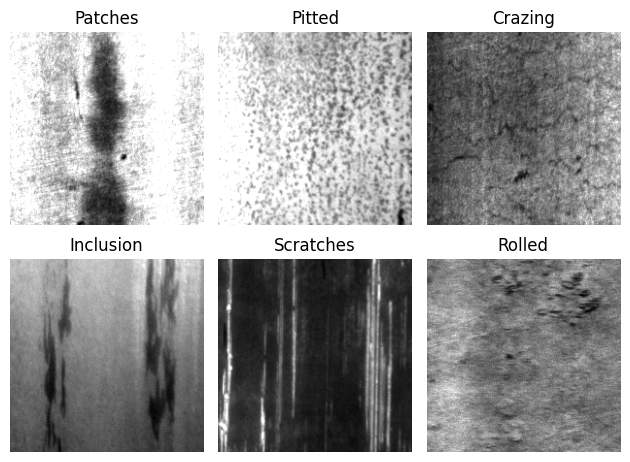

In [ ]:
# get sample images
categories = os.listdir('/content/NEU Metal Surface Defects Data/train')
for i, category in enumerate(categories):
    # Get the first image file in the category folder
    category_path = os.path.join(train_folder, category)
    image_file = os.listdir(category_path)[0]  # Get the first image
    image_path = os.path.join(category_path, image_file)

    # Load and display the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Display the image in the subplot
    plt.subplot(2, 3 , i+1)
    plt.imshow(image, cmap='gray')
    plt.title(category)
    plt.axis('off')

# Show the figure
plt.tight_layout()
plt.show()

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_dict = {'Patches': 0, 'Pitted': 1, 'Crazing': 2, 'Inclusion': 3, 'Scratches': 4, 'Rolled': 5}
    for label_name , label_value in label_dict.items():
        label_folder = os.path.join(train_folder , label_name)
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder , filename)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img , (64,64))
            img_normalised = img_resized/255.0
            images.append(img_normalised)
            labels.append(label_value)
    return np.array(images), np.array(labels)



In [ ]:
train_images, train_labels = load_images_from_folder(train_folder)
test_images , test_labels = load_images_from_folder(test_folder)
val_images , val_labels = load_images_from_folder(val_folder)

In [ ]:
# we have to reduce the size of dataset
x_train , _ , y_train , _ = train_test_split(train_images , train_labels , test_size = 0.0001 ,random_state = 42 , shuffle = True)
x_test , _ , y_test , _ = train_test_split(test_images , test_labels , test_size = 0.0001 ,random_state = 42 , shuffle = True)
x_val , _ , y_val , _ = train_test_split(val_images , val_labels , test_size = 0.0001 ,random_state = 42 , shuffle = True)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(1655, 64, 64, 3)
(1655, 64, 64, 3)
(1655, 64, 64, 3)


In [ ]:
# Define the number of layers and qubits
n_layers = 1  # You can increase this to experiment with more layers
dev = qml.device('default.qubit', wires=4)

# Define the quantum circuit with learnable parameters
# We are using a trainable random parameter generator instead of fixed ones
params = np.random.uniform(0, 2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Use RY gates as part of an embedding layer for the image data
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)  # Apply Ry rotations to qubits

    # Apply RandomLayers, where parameters will be updated during training
    RandomLayers(params, wires=list(range(4)))  # Random quantum layers

    # Measure the expectation value of the Pauli Z operator for each qubit
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with multiple applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))  # We get a 4-channel output due to PauliZ measurements

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Take a 2x2 block from the image
            q_results = circuit([
                image[j, k, 0],  # Top-left pixel
                image[j, k + 1, 0],  # Top-right pixel
                image[j + 1, k, 0],  # Bottom-left pixel
                image[j + 1, k + 1, 0]  # Bottom-right pixel
            ])

            # Map quantum results to the output array (downsample 2x2 to 1x1)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
SAVE_PATH = '/content/quanvolution'
PREPROCESS = True

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images) # Changed to q_train_images

    q_val_images = []
    print("\nQuantum pre-processing of val images:")
    for idx, img in enumerate(x_val):
        q_val_images.append(quanv(img))
    q_val_images = np.asarray(q_val_images)


    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test): # Changed y_test to x_test
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images) # Changed to q_test_images

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_val_images.npy", q_val_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)



# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_val_images = np.load(SAVE_PATH + "q_val_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of val images:

Quantum pre-processing of test images:


In [ ]:
# Resize the quantum-preprocessed images to a larger size
q_train_images_resized = tf.image.resize(q_train_images, (64, 64))
q_val_images_resized = tf.image.resize(q_train_images, (64, 64))
q_test_images_resized = tf.image.resize(q_test_images, (64, 64))

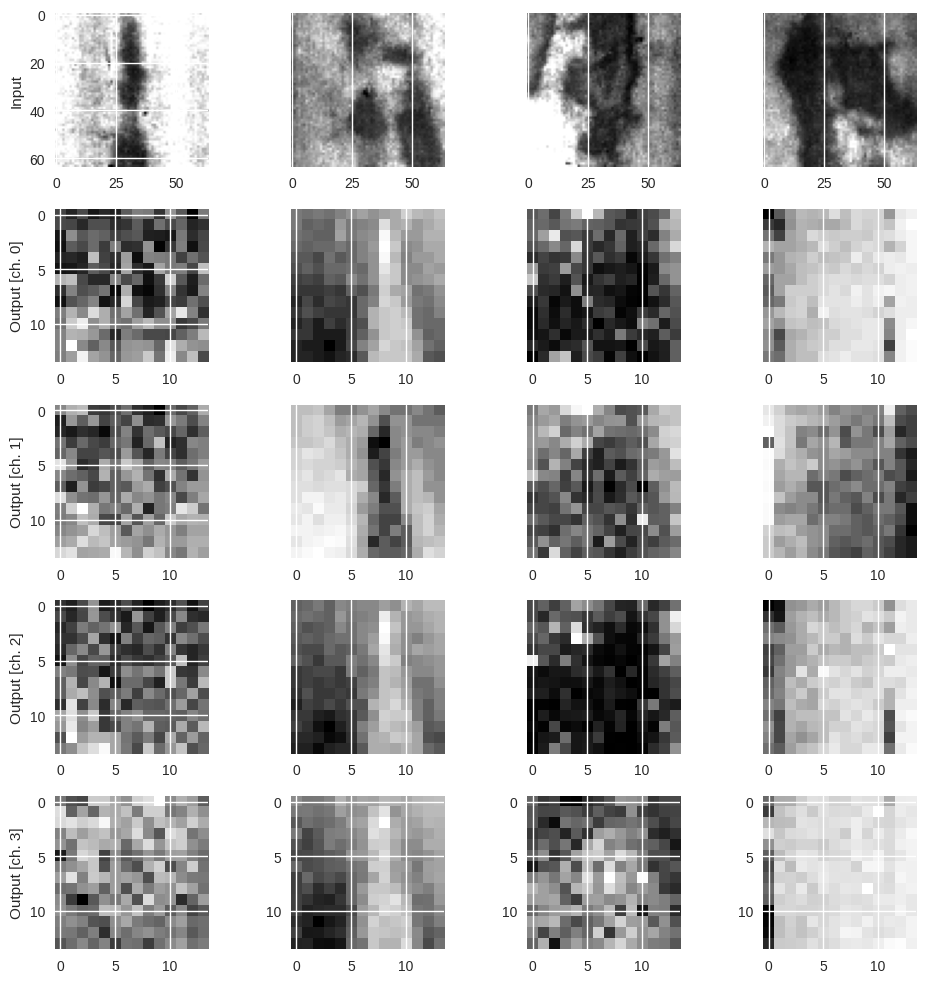

In [67]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModelEnhanced():
    model = models.Sequential([
        # Convolutional layers for classical feature extraction
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(14, 14, 4)),  # Adjust input shape
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Dense layer for classification
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(6, activation='softmax')  # 6 classes
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",  # Multi-class classification with integer labels
        metrics=["accuracy"],
    )
    return model

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.01)


In [ ]:
q_model_enhanced = MyModelEnhanced()

# Train the model using augmented data
q_history = q_model_enhanced.fit(
    q_train_images ,
    y_train,
    validation_data=(q_val_images, y_val),
    batch_size=4,
    epochs=100,
    verbose=2,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]
    )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
414/414 - 7s - 17ms/step - accuracy: 0.4121 - loss: 1.4523 - val_accuracy: 0.5432 - val_loss: 1.1505 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
414/414 - 8s - 20ms/step - accuracy: 0.6000 - loss: 1.0544 - val_accuracy: 0.6079 - val_loss: 1.0754 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
414/414 - 5s - 13ms/step - accuracy: 0.6586 - loss: 0.8899 - val_accuracy: 0.6526 - val_loss: 0.8905 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
414/414 - 8s - 19ms/step - accuracy: 0.7045 - loss: 0.7526 - val_accuracy: 0.6792 - val_loss: 0.8508 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
414/414 - 7s - 16ms/step - accuracy: 0.7

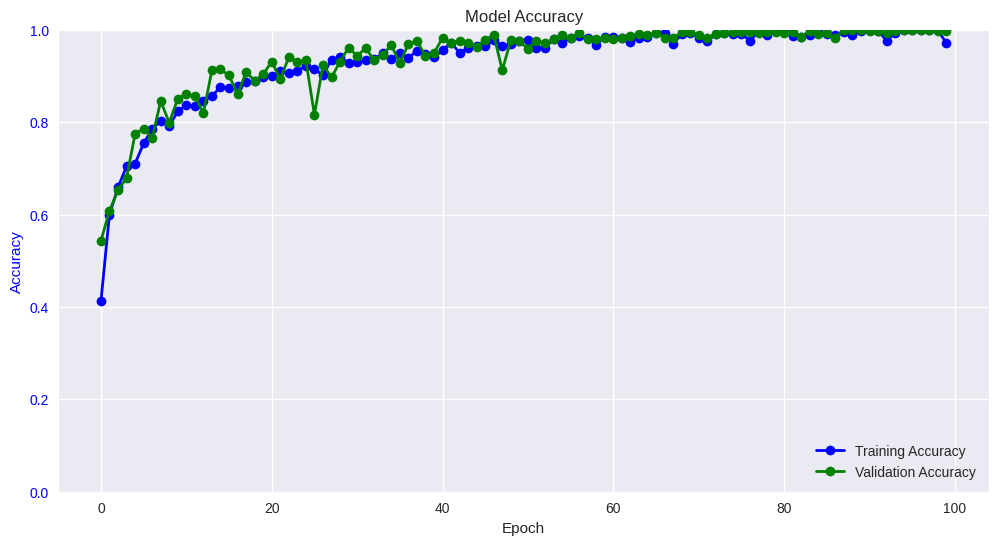

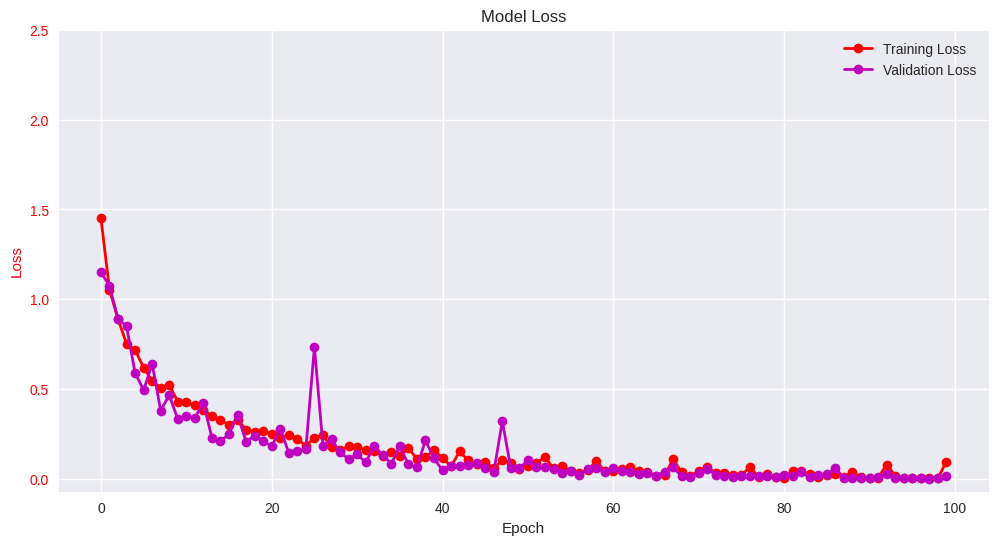

In [ ]:
import matplotlib.pyplot as plt

# Use seaborn style and update font size
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 12})

# Create the first plot for accuracy
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(q_history.history["accuracy"], "-ob", label="Training Accuracy", linewidth=2)
ax1.plot(q_history.history["val_accuracy"], "-og", label="Validation Accuracy", linewidth=2)
ax1.set_ylabel("Accuracy", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylim([0, 1])
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="lower right")
ax1.set_title("Model Accuracy")

# Create the second plot for loss
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(q_history.history["loss"], "-or", label="Training Loss", linewidth=2)
ax2.plot(q_history.history["val_loss"], "-om", label="Validation Loss", linewidth=2)
ax2.set_ylabel("Loss", color="red")
ax2.set_xlabel("Epoch")
ax2.set_ylim(top=2.5)
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="upper right")
ax2.set_title("Model Loss")

plt.show()

In [ ]:
y_pred = q_model_enhanced.predict(q_test_images)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert predictions to class labels

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_classes)

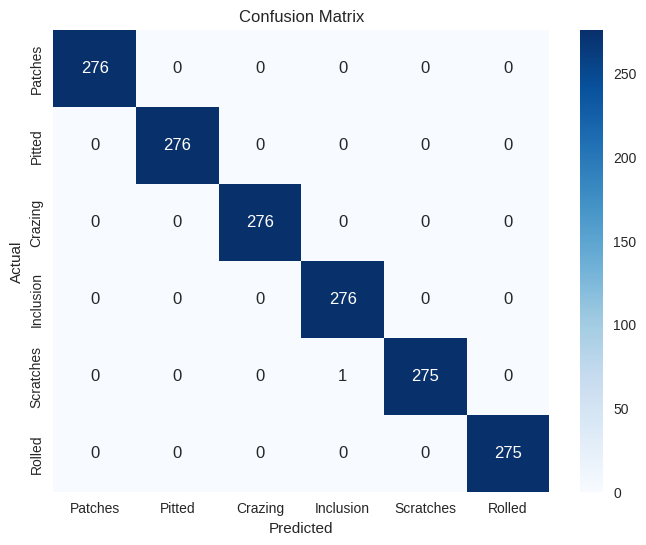

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have y_test (true labels) and y_pred_classes (predicted labels)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_classes, average=None)  # Set average to None for per-class scores
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average=None)

# Print the results
for i, category in enumerate(categories):
    print(f"\nMetrics for class '{category}':")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")

# Calculate and print overall metrics (macro average)
precision_macro = precision_score(y_test, y_pred_classes, average='macro')
recall_macro = recall_score(y_test, y_pred_classes, average='macro')
f1_macro = f1_score(y_test, y_pred_classes, average='macro')

print(f"\nOverall Metrics (Macro Average):")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")
print(f"  F1-score: {f1_macro:.4f}")

Accuracy: 0.9994

Metrics for class 'Patches':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for class 'Pitted':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for class 'Crazing':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for class 'Inclusion':
  Precision: 0.9964
  Recall: 1.0000
  F1-score: 0.9982

Metrics for class 'Scratches':
  Precision: 1.0000
  Recall: 0.9964
  F1-score: 0.9982

Metrics for class 'Rolled':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Overall Metrics (Macro Average):
  Precision: 0.9994
  Recall: 0.9994
  F1-score: 0.9994


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have y_test (true labels) and y_pred_classes (predicted labels)

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=categories)

# Print the report
print(report)

              precision    recall  f1-score   support

     Patches       1.00      1.00      1.00       276
      Pitted       1.00      1.00      1.00       276
     Crazing       1.00      1.00      1.00       276
   Inclusion       1.00      1.00      1.00       276
   Scratches       1.00      1.00      1.00       276
      Rolled       1.00      1.00      1.00       275

    accuracy                           1.00      1655
   macro avg       1.00      1.00      1.00      1655
weighted avg       1.00      1.00      1.00      1655

